# Récupération des légendes

## Librairies

In [1]:
import re
import os
import cv2
import math
import time
import Levenshtein  # une bibliothèque Python pour calculer la distance de Levenshtein
import easyocr
import pytesseract
import fitz
import pdf2image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pylab import rcParams
#from IPython.display import Image
from pdf2image import convert_from_path
from imutils.object_detection import non_max_suppression

# Partie 1 : Cropper la légende

## Récupérer la page Completion log / Composite log

In [2]:
OUTLINES = ['Composite Log', 'Completion log', 'Completion Log', 'Composite log', 'Att. 8.7 - Composite log']
filename = "NO_Quad_15/15_3-6/15_3-6__WELL__15-03-06_PB-706-0776.pdf"
filename = "NO_Quad_15/15_3-2/15_3-2__WELL__15-03-02_PB-706-0789.pdf"
filename = "NO_Quad_15/15_5-4/15_5-4__WELL__15-05-04_PB-706-0384.pdf"

doc = fitz.open(filename)
toc = doc.get_toc()

for outline in toc:
    if outline[1] in OUTLINES:
        page_num = outline[2]
        break
        
print("Completion log à la page : ", page_num)

Completion log à la page :  104


## Get the page concerned

In [3]:
"""page = convert_from_path(filename, first_page = page_num, last_page = page_num, transparent = True)[0]

# Définir la taille de chaque image découpée
taille = 5000

# Récupérer la largeur et la hauteur de l'image
largeur, hauteur = page.size

# Boucler sur les positions de découpage et découper l'image
lst_img = []
i = 0
for y in range(0, hauteur, taille):
    boite = (0, y, largeur, y+taille)
    region = page.crop(boite)
    lst_img.append(region)
    nom_fichier = "crop/image_{}.jpg".format(i)
    region.save(nom_fichier)
    i += 1"""

'page = convert_from_path(filename, first_page = page_num, last_page = page_num, transparent = True)[0]\n\n# Définir la taille de chaque image découpée\ntaille = 5000\n\n# Récupérer la largeur et la hauteur de l\'image\nlargeur, hauteur = page.size\n\n# Boucler sur les positions de découpage et découper l\'image\nlst_img = []\ni = 0\nfor y in range(0, hauteur, taille):\n    boite = (0, y, largeur, y+taille)\n    region = page.crop(boite)\n    lst_img.append(region)\n    nom_fichier = "crop/image_{}.jpg".format(i)\n    region.save(nom_fichier)\n    i += 1'

### Cropper une image

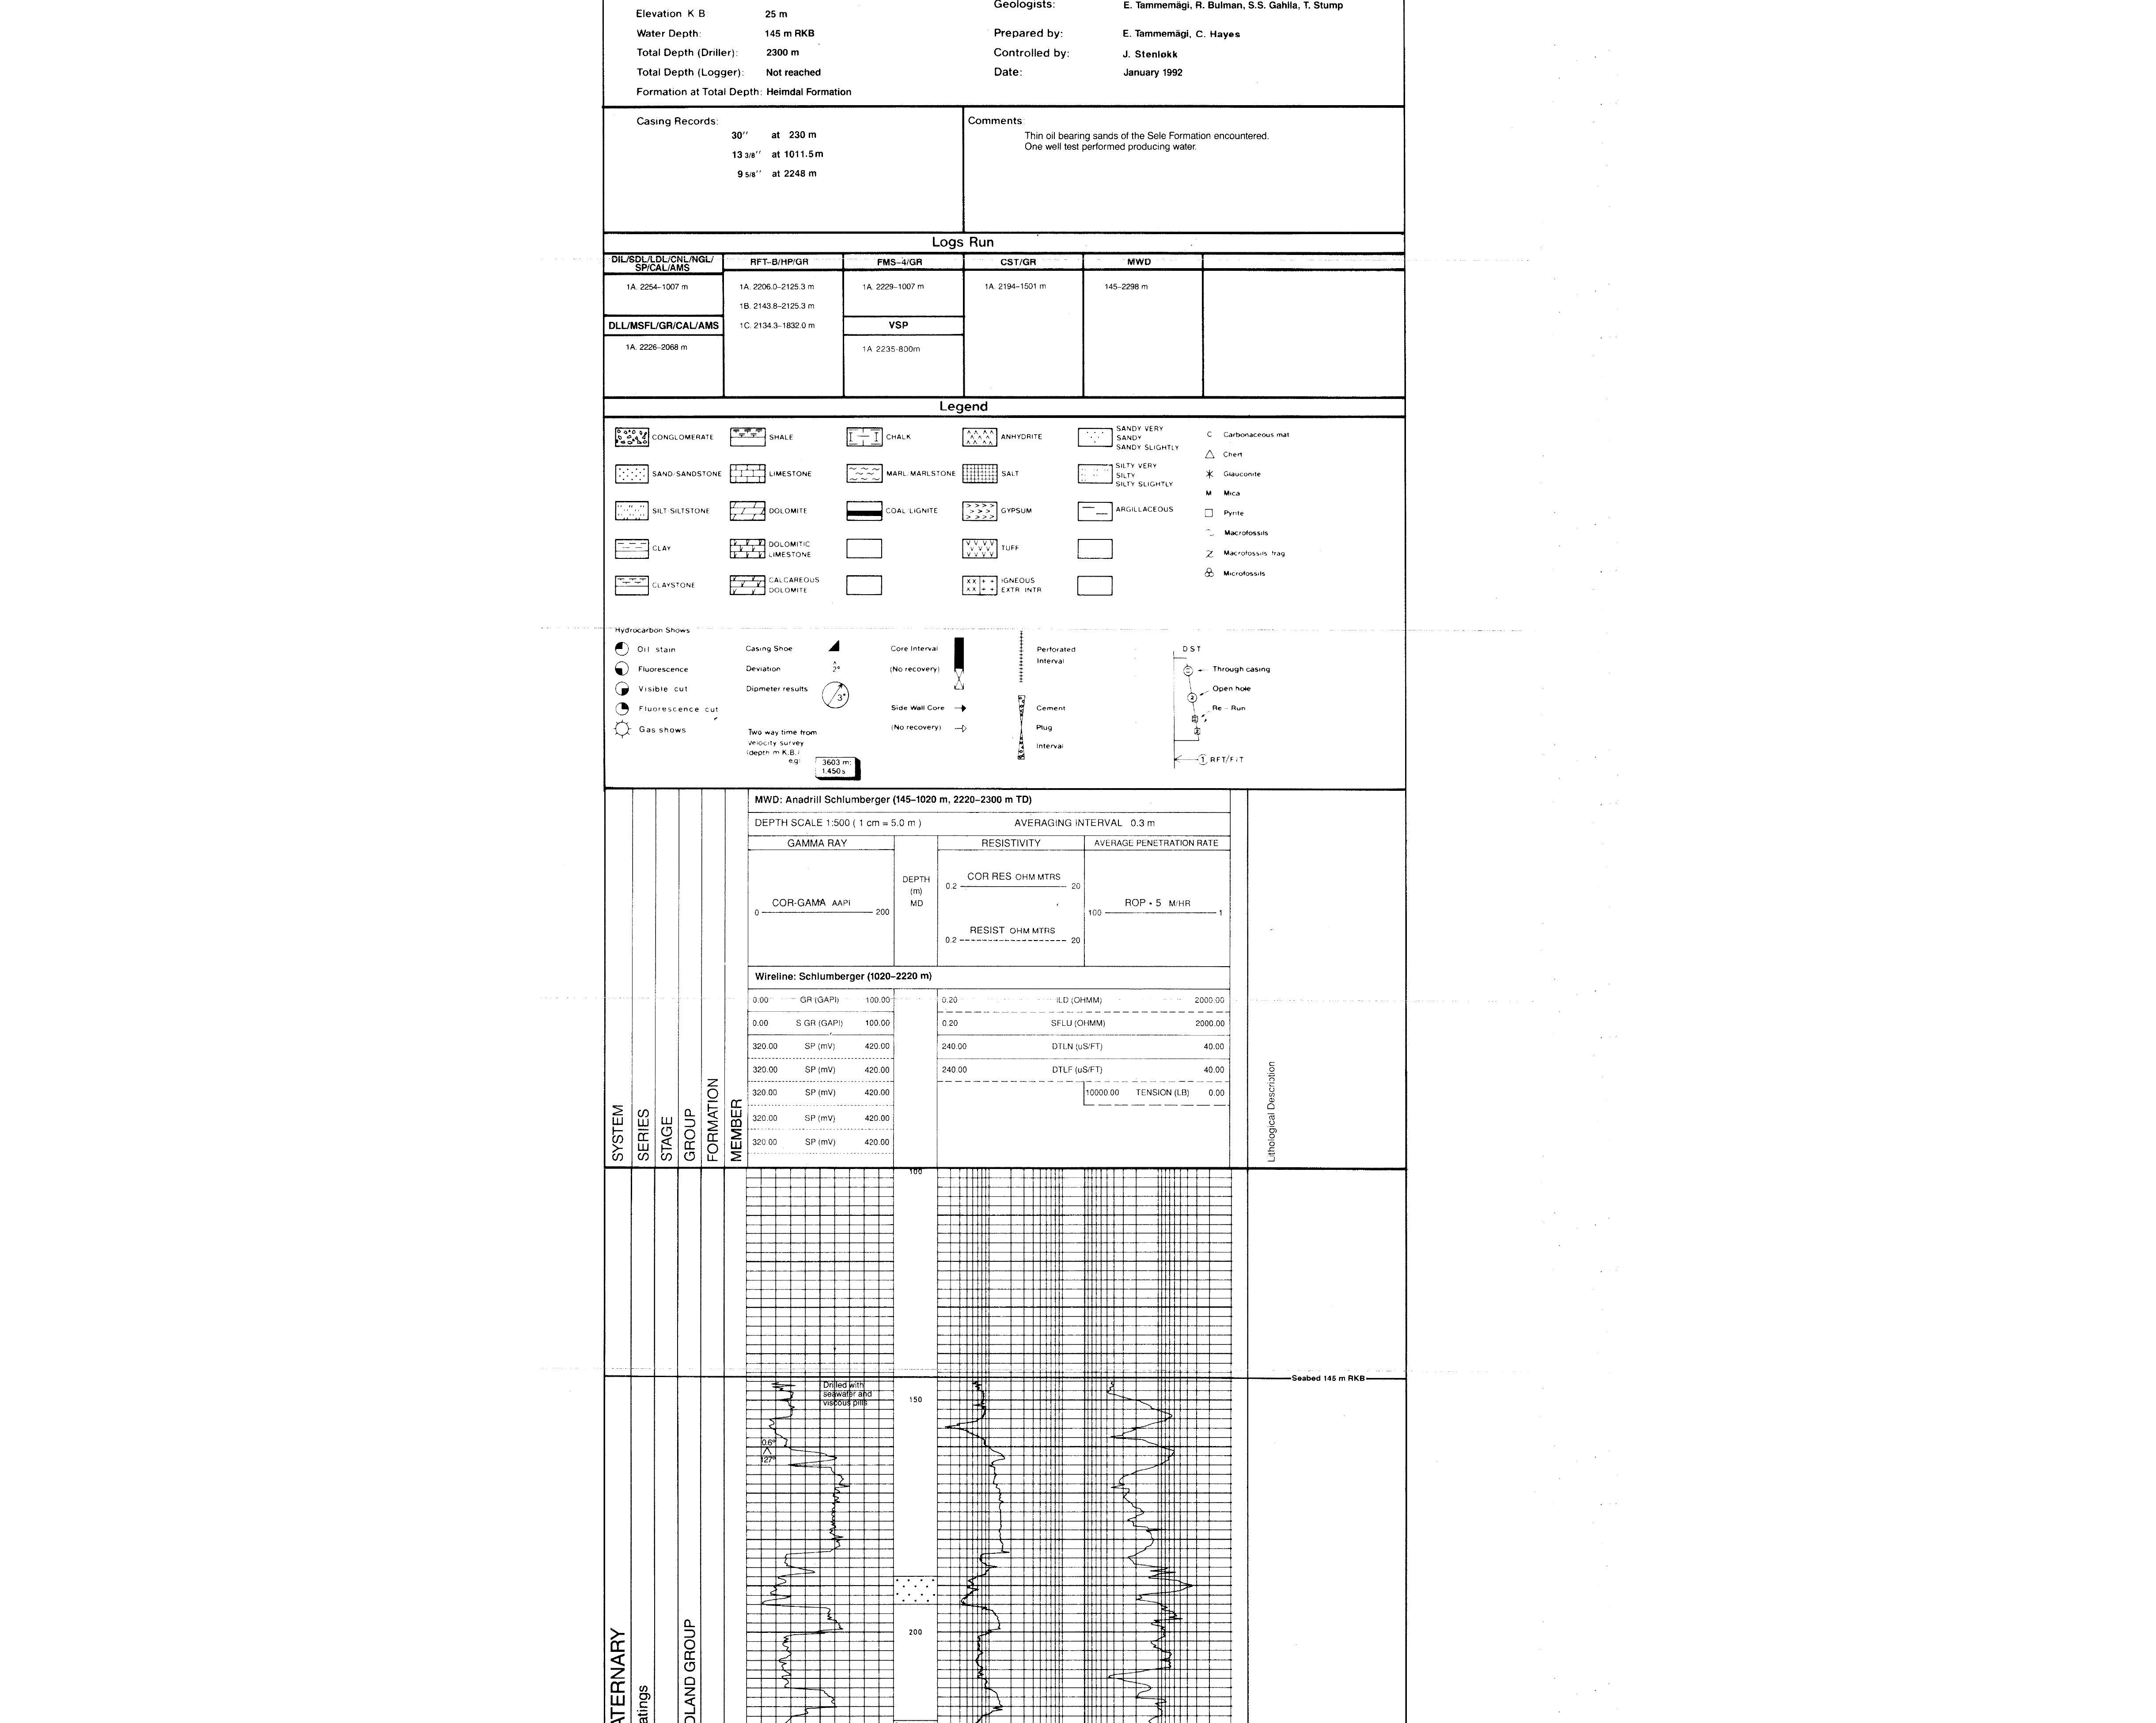

In [4]:
Image.MAX_IMAGE_PIXELS = None

page = convert_from_path(filename, first_page=page_num, last_page=page_num)[0]

# Obtenir la taille de l'image
largeur, hauteur = page.size

# Sélectionner la partie supérieure de l'image
partie_superieure = page.crop((0, 1100, largeur, 5000))

partie_superieure.save('legende.png')

partie_superieure

## Image de la légende

In [5]:
def contous_image(nom_file):
    # Charger l'image
    img = cv2.imread(nom_file)

    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Appliquer un flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Détecter les contours dans l'image
    edged = cv2.Canny(blurred, 30, 150)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #Création directory
    if not os.path.exists('page/'):
        os.makedirs('page/')

    boxes = []
    i = 0
    for contour in contours:

        # Calculer l'aire du contour
        area = cv2.contourArea(contour)
        hull = cv2.convexHull(contour)

        # Ignorer les contours trop petits ou trop grands
        # de base 4000
        # if area < 4000 or area > 100000000:
        if area < 4000 or area > 100000000:
            # Créer un rectangle à partir de l'élément convexe
        # x, y, w, h = cv2.boundingRect(hull)
        #  Découper les images selon ces parties convexes
        # region = img[y:y+h, x:x+w]
            continue
    
        # Trouver le rectangle qui englobe le contour
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = box.astype('int')

        # Enregistrer l'image du rectangle
        x, y, w, h = cv2.boundingRect(contour)
        roi = img[y:y + h, x:x + w]
        cv2.imwrite('page/'+str(i)+'.png', roi)

        i = i + 1
        # Dessiner le rectangle sur l'image
        cv2.drawContours(img, [box], 0, (0, 0, 255), 2)
    return img

"""
img = cv2.imread('34.png')
print(img.size)
"""
# taille bonne 1852440
# taille trop grande : 15701931

"\nimg = cv2.imread('34.png')\nprint(img.size)\n"

In [6]:
import re

def guess_word(mot, dictionnaire):
    mot_res = []
    for mot_dico in dictionnaire:
        mot = mot.lower()
        removed_chars = ".,!'/"
        chars = '[%s]+' % re.escape(removed_chars)
        res = re.sub(chars, '', mot)
        if ((len(mot_dico) == len(mot)) or (len(mot_dico) == len(mot)-1) or (len(mot_dico) == len(mot)+1)):
            count = 0
            if (len(mot) < len(mot_dico)):
                taille = len(mot)
            else: 
                taille = len(mot_dico)
            for i in range(taille):
                if mot[i] == mot_dico[i]:
                    count += 1
            if (len(mot_dico) <= 4):
                if count >= 2:
                    mot_res.append(mot_dico)
            if (len(mot_dico) < 6):
                if count >= 3:
                    mot_res.append(mot_dico)
            if (len(mot_dico) >= 6):
                if count >= 5:
                    mot_res.append(mot_dico)
                    
    max_count = 0
    if (len(mot_res)>1):
        for i in range(len(mot_res)):
            for j in range(len(mot_res[i])):
                if j == 0 :
                    if (mot_res[i][j] == mot[j]) or (mot_res[i][j+1] == mot[j]):
                        count += 1
                elif j == len(mot_res[i])-1:
                    if (mot_res[i][j] == mot[j]) or (mot_res[i][j-1] == mot[j]):
                        count += 1
                else : 
                    if (mot_res[i][j] == mot[j]) or (mot_res[i][j-1] == mot[j]) or (mot_res[i][j+1] == mot[j]):
                        count += 1
            if count > max_count:
                max_count = count
                sol = mot_res[i]
        return sol
                
    if (len(mot_res) == 0):
        return mot
    else: 
        return mot_res[0]

In [7]:
def trouve_image_legende():
    image_legende =  []
    for i in range(num_files): 
        rcParams['figure.figsize'] = 8,16

        # here you can use any other language you want
        reader = easyocr.Reader(['en'])

        # using the read text function generating the text from image
        nom_path = 'page/'+str(i)+'.png'
    
        output = reader.readtext(nom_path)
        dictionnaire = ['legend', 'lithologic', 'symbols', 'lithologic symbols']
    
        for (bbox, text, prob) in output:
            mot_resultat = guess_word(text, dictionnaire)
            if not(i == num_files-1):
                if (mot_resultat == 'legend') or (mot_resultat == 'lithologic') or (mot_resultat == 'symbols') or (mot_resultat == 'lithologic symbols') :
                    image_legende.append('page/'+str(i)+'.png')
                    image_legende.append('page/'+str(i-1)+'.png')
                    return image_legende
    return image_legende

In [8]:
def contour(image_legende):
    # Charger l'image
    img = cv2.imread(image_legende)

    # Convertir l'image en niveaux de gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Appliquer un flou gaussien pour réduire le bruit
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Détecter les contours dans l'image
    edged = cv2.Canny(blurred, 30, 150)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #Création directory
    if not os.path.exists('legende/'):
        os.makedirs('legende/')

    boxes = []
    i = 0
    for contour in contours:

        # Calculer l'aire du contour
        area = cv2.contourArea(contour)
   
    
        # Ignorer les contours trop petits ou trop grands
        if area < 4000:
             continue
    
        # Trouver le rectangle qui englobe le contour
        rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rect)
        box = box.astype('int')

        # Enregistrer l'image du rectangle
        x, y, w, h = cv2.boundingRect(contour)
        roi = img[y:y + h, x:x + w]
        cv2.imwrite('legende/'+str(i)+'.png', roi)

        i = i + 1
        # Dessiner le rectangle sur l'image
        cv2.drawContours(img, [box], 0, (0, 0, 255), 2)
    

def trouver_path_image_legende(image_legende):
    for i in range(len(image_legende)):
        contour(image_legende[i])
        path = "legende" # Remplacez "chemin_vers_votre_dossier" par le chemin d'accès à votre dossier
        files = os.listdir(path)

        num_files = len(files)

        if (num_files > 0):
            return image_legende[i]

#### Fct ppale

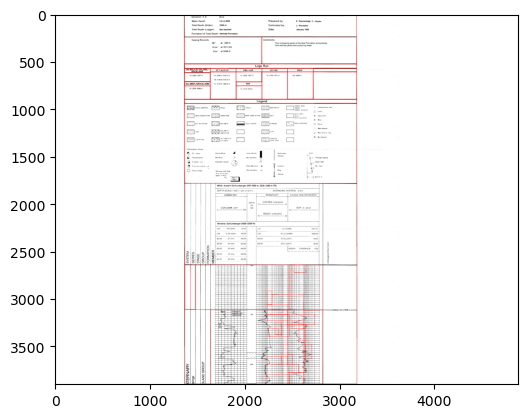

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.
CUDA not available - defaulting to CPU. Note: This module is much

['page/28.png', 'page/27.png']


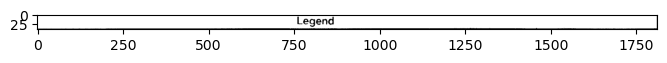

In [9]:
taille = 0
path = 'legende.png'
while (taille == 0) or (taille > 2000000):
    img = contous_image(path)
    # Afficher l'image avec les rectangles extraits
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    path = "page" # Remplacez "chemin_vers_votre_dossier" par le chemin d'accès à votre dossier
    files = os.listdir(path)

    num_files = len(files)

    image_legende = trouve_image_legende()

    print(image_legende)
    
    path = trouver_path_image_legende(image_legende)
    img = cv2.imread(path)
    taille = img.size
    # Afficher l'image avec les rectangles extraits
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [10]:
cv2.imwrite('legende.png', img)

True

# Partie 2 : Extraction des motifs

### Chronométrage

In [11]:
start_time = time.time()

## Récupérer le texte sur la légende rognée

In [12]:
# here you can use any other language you want
reader = easyocr.Reader(['en'])

#file_name = "motifs_legende/legende_rapports/15-3-2/leg_15-3-2.png"
#file_name = "motifs_legende/legende_rapports/15-3-6/leg_15-3-6.png"
file_name = 'page/27.png'
#Image("test_image.png")

# using the read text function generating the text from image
output = reader.readtext(file_name)
print(output)

# here we are only using first text form the image to show the bounding box
cord = output[0][0]
x_min, y_min = [int(min(idx)) for idx in zip(*cord)]
x_max, y_max = [int(max(idx)) for idx in zip(*cord)]

# using matplotlib to show the bounding box rectangle around the text in image
image = cv2.imread('test_image.png')
cv2.rectangle(image,(x_min,y_min),(x_max,y_max),(0,0,255),2)

#plt.imwrite(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[1157, 15], [1267, 15], [1267, 35], [1157, 35]], 'SANDY VERY', 0.9823968873522283), ([[105, 35], [249, 35], [249, 55], [105, 55]], 'CONGLOMERATE', 0.8268028118345672), ([[371, 35], [429, 35], [429, 55], [371, 55]], 'SHALE', 0.9824839959517081), ([[637, 37], [697, 37], [697, 55], [637, 55]], 'CHALK', 0.9744460381764979), ([[896, 32], [996, 32], [996, 56], [896, 56]], 'ANHYDRITE', 0.987525539711777), ([[1159, 39], [1219, 39], [1219, 55], [1159, 55]], 'SANDY', 0.9873600663843035), ([[1400, 32], [1553, 32], [1553, 49], [1400, 49]], 'Carbonaceous mat', 0.8990317640445351), ([[60, 42], [88, 42], [88, 66], [60, 66]], '4L=', 0.08467209274123225), ([[1159, 61], [1217, 61], [1217, 77], [1159, 77]], 'SANDY', 0.9882911197736078), ([[1223, 61], [1303, 61], [1303, 79], [1223, 79]], 'SLIGHTLY', 0.7901911055138726), ([[1401, 77], [1447, 77], [1447, 93], [1401, 93]], 'Cher', 0.4894949197769165), ([[1157, 103], [1253, 103], [1253, 119], [1157, 119]], 'SILTY VERY', 0.8536523787663526), ([[106, 114], [

### Récupération des mots, de leurs coord et transition mot bizarre

In [13]:
dictionnaire = [
    'pyrite', 'to', 'limestone', 'Marl', 'glauconite', 'bitumen', 
    'dolomite', 'mico', 'nannofossil', 'fine', 'grained', 
    'coarse', 'ooze', 'sand', 'sandstone', 'siderite',
    'clasts', 'flame', 'dewatering' ,'deflected', 'around', 'nodular'
    'diamict', 'diamictite', 'with', 'silt', 'clay',
    'matrix', 'foraminifer', 'silty', 'sandy', 'calcareous',
    'clayey', 'conglomerate', 'diatom', 'siltstone', 'breccia',
    'radiolarian', 'volcanic', 'ash', 'or', 'tuff', 'chalk',
    'claystone', 'silt-sized', 'sand-sized', 'serpentine','limestone',
    'chert', 'sand-silt-clay', 'sheared', 'phacoidal'
    'rock', 'lignite', 'sand', 'anhydrite', 'dolomite',
    'chalk', 'clay', 'claystone', 'coal', 'coal lignite',
    'conglomerate', 'dolomite', 'dolomitic', 'gypsum',
    'igneous', 'limestone', 'marl', 'marlstone', 'rock', 'salt',
    'clay', 'sandstone', 'fining-upward', 'trend', 'calcite', ''
    'shale', 'silt', 'siltstone', 'tuff']

dictionnaire = list(set(dictionnaire))

In [14]:
def correction_word(word : str, dictionnary : dict) -> str:
    liste_mots = word.split()
    liste_mots = [mot.lower() for mot in liste_mots]
    lst_sentence = []
    for mot in liste_mots:
        distances = {}
        for legende_mot in dictionnaire:
            distances[legende_mot] = Levenshtein.distance(mot, legende_mot)
        
        if np.min(list(distances.values())) > 5:
            lst_sentence.append(mot)
        else :
            lst_sentence.append(min(distances, key=distances.get))
    
    print(np.min(list(distances.values())))
    return ' '.join(lst_sentence)

In [15]:
dict_mot_coord = {}

for i, word_legend in enumerate(output):
    #print(word_legend)
    coord, txt, proba = word_legend
    
    x_min, y_min = [int(min(idx)) for idx in zip(*coord)]
    x_max, y_max = [int(max(idx)) for idx in zip(*coord)]
    
    # using matplotlib to show the bounding box rectangle around the text in image
    rect = cv2.rectangle(image,(x_min,y_min),(x_max,y_max),(0,0,255),2)

    # Compute the center point of the rectangle
    x_center = x_min #int((x_min + x_max) / 2)
    y_center = y_max #int((y_min + y_max) / 2)
    
    # Correction du mot
    nouveau_mot = correction_word(txt, dictionnaire) if proba < 0.4 else txt
    
    dict_mot_coord[nouveau_mot] = {
        "proba" : proba,
        "x_min" : x_min,
        "x_max" : x_max,
        "y_min" : y_min,
        "y_max" : y_max
    }
    # Print the center point coordinates
    print(f"{txt} : {nouveau_mot} // {proba}")

SANDY VERY : SANDY VERY // 0.9823968873522283
CONGLOMERATE : CONGLOMERATE // 0.8268028118345672
SHALE : SHALE // 0.9824839959517081
CHALK : CHALK // 0.9744460381764979
ANHYDRITE : ANHYDRITE // 0.987525539711777
SANDY : SANDY // 0.9873600663843035
Carbonaceous mat : Carbonaceous mat // 0.8990317640445351
3
4L= : to // 0.08467209274123225
SANDY : SANDY // 0.9882911197736078
SLIGHTLY : SLIGHTLY // 0.7901911055138726
Cher : Cher // 0.4894949197769165
SILTY VERY : SILTY VERY // 0.8536523787663526
SAND SANDSTONE : SAND SANDSTONE // 0.9832201940920695
LIMESTONE : LIMESTONE // 0.585873699613494
MARLAMARLSTONE : MARLAMARLSTONE // 0.6058487375345959
SALT : SALT // 0.9897571206092834
SILTY : SILTY // 0.8892845439691154
Glauconite : Glauconite // 0.990532105137435
Silty SLIGATLY : Silty SLIGATLY // 0.7212478995908572
Mica : Mica // 0.9924288392066956
SILT SILTSTONE : SILT SILTSTONE // 0.8157601769378915
DOLOMitE : DOLOMitE // 0.7483404134910326
COAL : COAL // 0.8916409611701965
LIGNITE : LIGNITE /

## Récupérer les rectangles

In [16]:
img = cv2.imread(file_name)

# Convertir l'image en niveaux de gris
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Appliquer un flou gaussien pour réduire le bruit
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Appliquer une binarisation adaptative pour mettre en évidence les contours
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

# Trouver les contours de l'image
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

dict_rect = {}
convex_contours = []
j = 0

lst_aire_w_h = []
lst_h, lst_w, lst_aire, lst_center_point = [], [], [], []
# Extraire les rectangles de l'image en utilisant les contours trouvés

for contour in contours:
    # Récupérer les contours convexes
    hull = cv2.convexHull(contour)
    area = cv2.contourArea(hull)
           
    print(area)
    
    # Les accepter selon un aire minimum
    if area > 1000 and area < 10000 :
        # Créer un rectangle à partir de l'élément convexe
        x, y, w, h = cv2.boundingRect(hull)
        
        lst_aire_w_h.append({
            "aire" : area,
            "rect" : (x, y, w, h),
            "hull" : hull
        })
        
        lst_h.append(h)
        lst_w.append(w)
        lst_aire.append(area)
        lst_center_point.append((x + w//2, y + h //2))
        
# Calculer la médiane des aires
med_h = np.median(lst_h)
med_w = np.median(lst_w)
med_aire = np.median(lst_aire) 

for aire_w_h in lst_aire_w_h:
    x, y, w, h = aire_w_h["rect"]
    aire = aire_w_h["aire"]
    hull = aire_w_h["hull"]
    
    if (h > med_h*6//7) and (w > med_w*6//7) and (aire > med_aire*6//7):
        nom_fichier = f"rect_{j}"
        dict_rect[nom_fichier] = (x, y, w, h)
        convex_contours.append(hull)
        j += 1

12.5
6.5
2.0
2.0
2.0
11.5
9.0
13.0
670.0
8.5
4.0
56.0
227.5
64.0
38.5
25.0
12.0
1.5
110.0
7.0
0.0
1.5
9.5
106.0
211.0
91.0
92.5
5.5
90.0
57.5
29.0
115.0
71.5
64.5
73.5
67.5
51.0
5408.5
63.0
4.0
4.0
91.5
99.0
56.0
368.0
26.5
99.0
29.0
115.5
101.5
56.5
59.0
108.5
32.0
29.0
50.5
57.0
45.5
12.0
562.5
130.5
23.0
57.5
204.0
117.5
3.0
34.0
11.0
14.0
52.5
63.0
215.0
60.5
94.0
54.0
66.0
36.0
95.0
1.0
218.0
78.0
71.0
78.5
69.5
67.5
76.5
87.0
61.0
92.0
149.5
29.5
129.0
55.5
150.5
161.0
27.0
73.5
34.5
145.5
283.0
107.5
9.0
1306.5
29.5
35.5
36.5
23.0
15.0
72.0
55.5
71.5
69.0
71.5
68.0
68.0
64.5
57.5
69.0
24.0
69.5
69.0
57.5
52.0
56.0
50.0
87.5
50.5
48.5
42.0
52.0
52.0
34.0
27.0
113.0
70.0
66.0
105.0
99.0
112.5
66.0
247.5
262.5
5.5
137.5
716.5
1232.5
94.5
14.5
68.0
68.5
57.5
53.5
60.5
32.5
29.5
61.0
62.5
104.5
77.0
74.0
59.0
26.0
68.0
26.5
76.0
84.0
43.5
30.0
94.0
356.0
3.0
96.5
399.5
4.0
167.0
1.0
8755.5
3030.0
800.5
11.0
8.0
151.0
14.0
30.5
93.0
18.5
193.5
93.0
24.5
30.0
25.0
17.0
68.5
155.0
61.0


## Attribuer à chaque rectangle la légende qui lui va

In [17]:
# Pour chaque mot : trouver la boite la plus proche
dict_mot_rect = {}

dict_mot_coord_copy = dict_mot_coord.copy()

for mot, coord in dict_mot_coord_copy.items():    
    # mot = xmin et ymax
    x_mot, y_mot = coord["x_min"], coord["y_max"]

    lst_distance_boite = []
    
    for key_rect in dict_rect.keys():
        x, y, w, h = dict_rect[key_rect]
        x_box, y_box = x + w, y + h // 2
        
        dist_eucli = math.sqrt((y_box - y_mot)**2 + (x_box - x_mot)**2)
        lst_distance_boite.append(dist_eucli)
    
    # On trouve la clé du rectangle qui nous concerne
    dict_mot_coord[mot]["dist_rect"] = np.min(lst_distance_boite)
    dict_mot_coord[mot]["rect"] = list(dict_rect.keys())[np.argmin(lst_distance_boite)]
    
    dict_mot_rect[mot] = list(dict_rect.keys())[np.argmin(lst_distance_boite)]

del(dict_mot_coord_copy)

In [18]:
print(dict_mot_rect)

{'SANDY VERY': 'rect_21', 'CONGLOMERATE': 'rect_25', 'SHALE': 'rect_23', 'CHALK': 'rect_24', 'ANHYDRITE': 'rect_22', 'SANDY': 'rect_21', 'Carbonaceous mat': 'rect_21', 'to': 'rect_2', 'SLIGHTLY': 'rect_21', 'Cher': 'rect_16', 'SILTY VERY': 'rect_16', 'SAND SANDSTONE': 'rect_18', 'LIMESTONE': 'rect_8', 'MARLAMARLSTONE': 'rect_20', 'SALT': 'rect_19', 'SILTY': 'rect_16', 'Glauconite': 'rect_16', 'Silty SLIGATLY': 'rect_16', 'Mica': 'rect_11', 'SILT SILTSTONE': 'rect_15', 'DOLOMitE': 'rect_14', 'COAL': 'rect_13', 'LIGNITE': 'rect_13', 'GYPSUM': 'rect_12', 'ARGHLLACEOUS': 'rect_11', 'pyrite': 'rect_11', 'Macrofossils': 'rect_6', 'CLAY': 'rect_9', 'DOLOmITIC': 'rect_8', 'TUFF': 'rect_7', 'Macrofossis': 'rect_6', 'flame': 'rect_6', 'Microfossils': 'rect_1', 'CALCAREOUS': 'rect_5', "'GNEOUS": 'rect_2', 'CLAYSTONE': 'rect_3', 'DOLOMITE': 'rect_5', 'INTA': 'rect_2', 'Hydrocarbon Shows': 'rect_3', 'Oi[': 'rect_3', 'stain': 'rect_3', 'Casing Shoe': 'rect_5', 'Core Interval': 'rect_4', 'Pertorated'

In [19]:
import json
print(json.dumps(dict_mot_coord, indent=4))

{
    "SANDY VERY": {
        "proba": 0.9823968873522283,
        "x_min": 1157,
        "x_max": 1267,
        "y_min": 15,
        "y_max": 35,
        "dist_rect": 12.083045973594572,
        "rect": "rect_21"
    },
    "CONGLOMERATE": {
        "proba": 0.8268028118345672,
        "x_min": 105,
        "x_max": 249,
        "y_min": 35,
        "y_max": 55,
        "dist_rect": 10.198039027185569,
        "rect": "rect_25"
    },
    "SHALE": {
        "proba": 0.9824839959517081,
        "x_min": 371,
        "x_max": 429,
        "y_min": 35,
        "y_max": 55,
        "dist_rect": 10.770329614269007,
        "rect": "rect_23"
    },
    "CHALK": {
        "proba": 0.9744460381764979,
        "x_min": 637,
        "x_max": 697,
        "y_min": 37,
        "y_max": 55,
        "dist_rect": 11.180339887498949,
        "rect": "rect_24"
    },
    "ANHYDRITE": {
        "proba": 0.987525539711777,
        "x_min": 896,
        "x_max": 996,
        "y_min": 32,
        "y_max":

In [20]:
dict_rect_mot = {}
for word, rect in dict_mot_rect.items():
    word_y_min = dict_mot_coord[word]["y_min"]
    word_y_max = dict_mot_coord[word]["y_max"]
    rect_y_min = dict_rect[rect][1]
    rect_y_max = dict_rect[rect][1]+dict_rect[rect][3] # = (x, y, w, h)
    
    if word_y_max > rect_y_max or rect_y_min > word_y_min:
        print(word_y_max, rect_y_max, rect_y_min, word_y_min)
    if word_y_max < rect_y_max + 20 and rect_y_min - 20 < word_y_min:
        if rect in dict_rect_mot.keys():
            dict_rect_mot[rect] += " " + word
        else:
            dict_rect_mot[rect] = word
        
print(dict_rect_mot)

35 69 24 15
77 69 24 61
79 69 24 61
93 152 106 77
119 152 106 103
161 152 106 141
181 237 191 165
271 322 275 253
363 405 359 347
493 405 358 473
535 405 358 515
537 405 358 519
535 404 357 515
533 404 357 517
535 405 358 519
535 405 359 517
561 405 358 545
584 405 358 559
579 404 357 561
581 404 357 561
584 405 359 559
625 405 358 605
671 405 358 657
626 404 357 606
625 405 359 607
672 405 358 652
667 823 768 651
667 405 358 651
667 405 359 651
667 405 359 651
721 405 358 694
723 823 768 703
723 823 768 705
713 823 768 695
749 823 768 731
753 405 358 737
786 405 359 762
769 823 768 751
715 405 358 692
{'rect_21': 'SANDY VERY SANDY Carbonaceous mat SLIGHTLY', 'rect_25': 'CONGLOMERATE 8', 'rect_23': 'SHALE', 'rect_24': 'CHALK', 'rect_22': 'ANHYDRITE', 'rect_2': "to 'GNEOUS INTA", 'rect_16': 'SILTY VERY SILTY Glauconite Silty SLIGATLY', 'rect_18': 'SAND SANDSTONE', 'rect_8': 'LIMESTONE DOLOmITIC', 'rect_20': 'MARLAMARLSTONE', 'rect_19': 'SALT', 'rect_15': 'SILT SILTSTONE', 'rect_14': 'DO

In [21]:
import os
dossier = "save_legend/15_3-2/"
dossier = "save_legend/15_5-4/"
#dossier = "save_legend/15-3-6/"

if not os.path.exists(dossier):
    os.makedirs(dossier)

acc = 0

for key_rect in dict_rect.keys():
    x, y, w, h = dict_rect[key_rect]
    
    if key_rect in dict_rect_mot:
        nom = dict_rect_mot[key_rect]
    else : 
        nom = f"unknow_{acc}"
        acc += 1
    
    # On enregistre la sous partie qu'on souhaite
    cv2.imwrite(f"{dossier}{nom}.jpg", img[y:y+h, x:x+w])
    
# Dessiner les contours simplifiés sur l'image originale
cv2.drawContours(img, convex_contours, -1, (255, 0, 0), 2)

print(f"Il y a {len(dict_rect.keys())} motifs dans cette légende")

# Afficher l'image avec les rectangles extraits
cv2.imwrite(f"{dossier}legend_with_crop.jpg", img)

Il y a 26 motifs dans cette légende


True

#### Fin chronométrage

In [22]:
print(f"Temps total = {time.time() - start_time}")

Temps total = 9.810905933380127


## Brouillon